<a href="https://colab.research.google.com/github/aquila00/MovieIt/blob/main/turnover_analise_etapa2_2_zenilton_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Previsão de Rotatividade de Funcionários com Machine Learning - Abordagem Metodológica Utilizando Dados Públicos

##Metodologia

Este experimento descreve 5 algoritmos de aprendizagem de máquina supervisionados, demonstra e avalia a capacidade destes algoritmos para prever a rotatividade de funcionários através de dados do Cadastro Geral de (CAGED) e ainda fornece uma visão geral quanto às diretrizes do preprocessamento do conjunto de dados a ser utilizado.

#**Bibliotecas**

In [ ]:
!pip install -q geopandas
!pip install -q mapclassify
!pip install -q joblib
!pip install -q -U dataprep
!pip install -q pandas-profiling
!pip install -q pyod
!pip install -U -q scikit-learn
!pip install -q roc-utils

# importando bibliotecas gerais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import roc_utils as ru

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# relatório automático
from dataprep.eda import create_report
from pandas_profiling import ProfileReport

# biblioteca do colab
from google.colab import drive

# Checagem de precisão
from sklearn.metrics import accuracy_score

# biblioteca manipulação de data
from datetime import date 

# importando biblioteca json
import json

# importando SVM
from sklearn import svm

# Visualização
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from statistics import median
%matplotlib inline

# bibliotecas geo
import seaborn as sns
import folium
from folium.plugins import HeatMap

# importando biblioteca shapely para operações com geometrias
from shapely.geometry import Point, LineString, Polygon

# imortanto biblioteca de processamento paralelo
#from joblib import parallel, delayed

In [ ]:
import warnings

warnings.filterwarnings('ignore')


#**Importação de Bases de Dados**

##Google Drive

In [ ]:
# acessando os arquivos no GoogleDrive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path = '/content/gdrive/MyDrive/caged'
uf_name = 'mg'

In [ ]:
ds_caged = pd.read_csv(f'{path}/data/ds_caged_{uf_name}_2022_final.csv', delimiter=',')
sedes = pd.read_csv(f'{path}/sedes_municipais2.txt', delimiter=';')

In [ ]:
sedes

,GEOCODIGO_MUNICIPIO,NOME_MUNICIPIO,LONGITUDE,LATITUDE
0,1100015,ALTA FLORESTA D'OESTE,-61.999824,-11.935540
1,1100023,ARIQUEMES,-63.033269,-9.908463
2,1100031,CABIXI,-60.544314,-13.499763
3,1100049,CACOAL,-61.442944,-11.433865
4,1100056,CEREJEIRAS,-60.818426,-13.195033
...,...,...,...,...
5560,5222005,VIANÓPOLIS,-48.513471,-16.742081
5561,5222054,VICENTINÓPOLIS,-49.807239,-17.732662
5562,5222203,VILA BOA,-47.057361,-15.034889
5563,5222302,VILA PROPÍCIO,-48.882422,-15.454635


In [ ]:
sedes['GEOCODIGO_MUNICIPIO'] = sedes['GEOCODIGO_MUNICIPIO'].astype('int64')//10

In [ ]:
ds_caged = pd.merge(left=ds_caged, right=sedes, how='left', left_on='municipio_cod', right_on='GEOCODIGO_MUNICIPIO')

In [ ]:
ds_caged

,ano_mes_referencia,uf_cod,municipio_cod,cnpj_cnae,cnpj_secao,cnpj_tipo,cnpj_tam_jan,trabalhador_cbo,trabalhador_categoria,trabalhador_grauinstrucao,...,cnpj_cnae_descr,trabalhador_cbo_descr,trabalhador_categoria_descr,nome_municipio,trabalhador_racacor_descr,trabalhador_sexo_descr,GEOCODIGO_MUNICIPIO,NOME_MUNICIPIO,LONGITUDE,LATITUDE
0,202201,31,311800,3321000,C,0,9,514320,101,5,...,Instalação de Máquinas e Equipamentos Industriais,Faxineiro (Desativado em 2010),"Empregado - Geral, inclusive o empregado públi...",CONGONHAS,Não informada,Homem,311800,CONGONHAS,-43.856893,-20.504643
1,202201,31,310190,1052000,C,0,1,252210,101,7,...,Fabricação de Laticínios,Contador,"Empregado - Geral, inclusive o empregado públi...",ALPINÓPOLIS,Não informada,Homem,310190,ALPINÓPOLIS,-46.389483,-20.861855
2,202201,31,311280,5510801,I,0,4,514320,101,7,...,Hotéis,Faxineiro (Desativado em 2010),"Empregado - Geral, inclusive o empregado públi...",CAPITÓLIO,Não informada,Mulher,311280,CAPITÓLIO,-46.054514,-20.614664
3,202201,31,313820,7732201,N,0,3,521140,101,9,...,Aluguel de Máquinas e Equipamentos para Constr...,Atendente de Lojas e Mercados,"Empregado - Geral, inclusive o empregado públi...",LAVRAS,Branca,Homem,313820,LAVRAS,-44.999931,-21.242870
4,202201,31,316570,4763602,G,0,3,521110,101,9,...,Comércio Varejista de Artigos Esportivos,Vendedor de Comercio Varejista,"Empregado - Geral, inclusive o empregado públi...",SENADOR FIRMINO,Branca,Mulher,316570,SENADOR FIRMINO,-43.104130,-20.918060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3572974,202209,31,313800,4930202,H,0,1,782510,101,3,...,"Transporte Rodoviário de Carga, Exceto Produto...",Motorista de Caminhao (Rotas Regionais e Inter...,"Empregado - Geral, inclusive o empregado públi...",LARANJAL,Parda,Homem,313800,LARANJAL,-42.480674,-21.363630
3572975,202209,31,310160,4754701,G,0,3,521110,101,7,...,Comércio Varejista de Móveis,Vendedor de Comercio Varejista,"Empregado - Geral, inclusive o empregado públi...",ALFENAS,Branca,Homem,310160,ALFENAS,-45.948918,-21.428178
3572976,202209,31,310620,8121400,N,0,8,517420,101,7,...,Limpeza em Prédios e em Domicílios,Vigia,"Empregado - Geral, inclusive o empregado públi...",BELO HORIZONTE,Preta,Homem,310620,BELO HORIZONTE,-43.926453,-19.937524
3572977,202209,31,310620,5611201,I,0,3,513205,101,7,...,Restaurantes e Similares,Cozinheiro Geral,"Empregado - Geral, inclusive o empregado públi...",BELO HORIZONTE,Não informada,Mulher,310620,BELO HORIZONTE,-43.926453,-19.937524


In [ ]:
ds_caged['trabalhador_movimentacao_target'] = [ds_caged['trabalhador_movimentacao_descr'][x].split(' ')[0] for x in ds_caged.index]
ds_caged

,ano_mes_referencia,uf_cod,municipio_cod,cnpj_cnae,cnpj_secao,cnpj_tipo,cnpj_tam_jan,trabalhador_cbo,trabalhador_categoria,trabalhador_grauinstrucao,...,trabalhador_cbo_descr,trabalhador_categoria_descr,nome_municipio,trabalhador_racacor_descr,trabalhador_sexo_descr,GEOCODIGO_MUNICIPIO,NOME_MUNICIPIO,LONGITUDE,LATITUDE,trabalhador_movimentacao_target
0,202201,31,311800,3321000,C,0,9,514320,101,5,...,Faxineiro (Desativado em 2010),"Empregado - Geral, inclusive o empregado públi...",CONGONHAS,Não informada,Homem,311800,CONGONHAS,-43.856893,-20.504643,Desligamento
1,202201,31,310190,1052000,C,0,1,252210,101,7,...,Contador,"Empregado - Geral, inclusive o empregado públi...",ALPINÓPOLIS,Não informada,Homem,310190,ALPINÓPOLIS,-46.389483,-20.861855,Admissão
2,202201,31,311280,5510801,I,0,4,514320,101,7,...,Faxineiro (Desativado em 2010),"Empregado - Geral, inclusive o empregado públi...",CAPITÓLIO,Não informada,Mulher,311280,CAPITÓLIO,-46.054514,-20.614664,Admissão
3,202201,31,313820,7732201,N,0,3,521140,101,9,...,Atendente de Lojas e Mercados,"Empregado - Geral, inclusive o empregado públi...",LAVRAS,Branca,Homem,313820,LAVRAS,-44.999931,-21.242870,Admissão
4,202201,31,316570,4763602,G,0,3,521110,101,9,...,Vendedor de Comercio Varejista,"Empregado - Geral, inclusive o empregado públi...",SENADOR FIRMINO,Branca,Mulher,316570,SENADOR FIRMINO,-43.104130,-20.918060,Admissão
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3572974,202209,31,313800,4930202,H,0,1,782510,101,3,...,Motorista de Caminhao (Rotas Regionais e Inter...,"Empregado - Geral, inclusive o empregado públi...",LARANJAL,Parda,Homem,313800,LARANJAL,-42.480674,-21.363630,Desligamento
3572975,202209,31,310160,4754701,G,0,3,521110,101,7,...,Vendedor de Comercio Varejista,"Empregado - Geral, inclusive o empregado públi...",ALFENAS,Branca,Homem,310160,ALFENAS,-45.948918,-21.428178,Desligamento
3572976,202209,31,310620,8121400,N,0,8,517420,101,7,...,Vigia,"Empregado - Geral, inclusive o empregado públi...",BELO HORIZONTE,Preta,Homem,310620,BELO HORIZONTE,-43.926453,-19.937524,Término
3572977,202209,31,310620,5611201,I,0,3,513205,101,7,...,Cozinheiro Geral,"Empregado - Geral, inclusive o empregado públi...",BELO HORIZONTE,Não informada,Mulher,310620,BELO HORIZONTE,-43.926453,-19.937524,Admissão


In [ ]:
ds_caged['trabalhador_movimentacao_target'].replace(['Culpa','Término','Não'], ['Desligamento','Desligamento','Não Identificado'], inplace = True)
ds_caged

,ano_mes_referencia,uf_cod,municipio_cod,cnpj_cnae,cnpj_secao,cnpj_tipo,cnpj_tam_jan,trabalhador_cbo,trabalhador_categoria,trabalhador_grauinstrucao,...,trabalhador_cbo_descr,trabalhador_categoria_descr,nome_municipio,trabalhador_racacor_descr,trabalhador_sexo_descr,GEOCODIGO_MUNICIPIO,NOME_MUNICIPIO,LONGITUDE,LATITUDE,trabalhador_movimentacao_target
0,202201,31,311800,3321000,C,0,9,514320,101,5,...,Faxineiro (Desativado em 2010),"Empregado - Geral, inclusive o empregado públi...",CONGONHAS,Não informada,Homem,311800,CONGONHAS,-43.856893,-20.504643,Desligamento
1,202201,31,310190,1052000,C,0,1,252210,101,7,...,Contador,"Empregado - Geral, inclusive o empregado públi...",ALPINÓPOLIS,Não informada,Homem,310190,ALPINÓPOLIS,-46.389483,-20.861855,Admissão
2,202201,31,311280,5510801,I,0,4,514320,101,7,...,Faxineiro (Desativado em 2010),"Empregado - Geral, inclusive o empregado públi...",CAPITÓLIO,Não informada,Mulher,311280,CAPITÓLIO,-46.054514,-20.614664,Admissão
3,202201,31,313820,7732201,N,0,3,521140,101,9,...,Atendente de Lojas e Mercados,"Empregado - Geral, inclusive o empregado públi...",LAVRAS,Branca,Homem,313820,LAVRAS,-44.999931,-21.242870,Admissão
4,202201,31,316570,4763602,G,0,3,521110,101,9,...,Vendedor de Comercio Varejista,"Empregado - Geral, inclusive o empregado públi...",SENADOR FIRMINO,Branca,Mulher,316570,SENADOR FIRMINO,-43.104130,-20.918060,Admissão
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3572974,202209,31,313800,4930202,H,0,1,782510,101,3,...,Motorista de Caminhao (Rotas Regionais e Inter...,"Empregado - Geral, inclusive o empregado públi...",LARANJAL,Parda,Homem,313800,LARANJAL,-42.480674,-21.363630,Desligamento
3572975,202209,31,310160,4754701,G,0,3,521110,101,7,...,Vendedor de Comercio Varejista,"Empregado - Geral, inclusive o empregado públi...",ALFENAS,Branca,Homem,310160,ALFENAS,-45.948918,-21.428178,Desligamento
3572976,202209,31,310620,8121400,N,0,8,517420,101,7,...,Vigia,"Empregado - Geral, inclusive o empregado públi...",BELO HORIZONTE,Preta,Homem,310620,BELO HORIZONTE,-43.926453,-19.937524,Desligamento
3572977,202209,31,310620,5611201,I,0,3,513205,101,7,...,Cozinheiro Geral,"Empregado - Geral, inclusive o empregado públi...",BELO HORIZONTE,Não informada,Mulher,310620,BELO HORIZONTE,-43.926453,-19.937524,Admissão


In [ ]:
#create_report(ds_caged)

#1 - Pré processamento
Lorem ipsum dolor sit amet, consectetur adipiscing elit. Donec quis velit eu lectus porttitor dignissim a ac neque. Vivamus ultricies.

## 1.1 - Tratamento de dados ausentes

In [ ]:
ds_caged.isna().sum()

ano_mes_referencia                    0
uf_cod                                0
municipio_cod                         0
cnpj_cnae                             0
cnpj_secao                            0
cnpj_tipo                             0
cnpj_tam_jan                          0
trabalhador_cbo                       0
trabalhador_categoria                 0
trabalhador_grauinstrucao             0
trabalhador_idade                     0
trabalhador_horascontratuais          0
trabalhador_racacor                   0
trabalhador_sexo                      0
trabalhador_movimentacao              0
trabalhador_salario                   0
trabalhador_movimentacao_descr        0
cnpj_tam_jan_descr                    0
trabalhador_grauinstrucao_descr       0
cnpj_secao_descr                      0
cnpj_cnae_descr                       0
trabalhador_cbo_descr              2180
trabalhador_categoria_descr           0
nome_municipio                        0
trabalhador_racacor_descr             0


In [ ]:
len(ds_caged.index)

3572979

In [ ]:
print(f'O percentual de valores vazios para trabalhador_cbo_descr é de: {str(round(ds_caged["trabalhador_cbo_descr"].isna().sum()/len(ds_caged.index)*100, 2))}%.')

O percentual de valores vazios para trabalhador_cbo_descr é de: 0.06%.


In [ ]:
ds_caged[ds_caged['trabalhador_cbo_descr'].isna()]

,ano_mes_referencia,uf_cod,municipio_cod,cnpj_cnae,cnpj_secao,cnpj_tipo,cnpj_tam_jan,trabalhador_cbo,trabalhador_categoria,trabalhador_grauinstrucao,...,trabalhador_cbo_descr,trabalhador_categoria_descr,nome_municipio,trabalhador_racacor_descr,trabalhador_sexo_descr,GEOCODIGO_MUNICIPIO,NOME_MUNICIPIO,LONGITUDE,LATITUDE,trabalhador_movimentacao_target
4248,202201,31,313760,6209100,J,0,3,212430,101,8,...,NaN,"Empregado - Geral, inclusive o empregado públi...",LAGOA SANTA,Branca,Mulher,313760,LAGOA SANTA,-43.895288,-19.625851,Admissão
5835,202201,31,311860,9430800,S,0,7,253405,105,9,...,NaN,Empregado - Contrato a termo firmado nos termo...,CONTAGEM,Branca,Mulher,311860,CONTAGEM,-44.066345,-19.943446,Admissão
11725,202201,31,310620,4771701,G,0,10,212430,101,9,...,NaN,"Empregado - Geral, inclusive o empregado públi...",BELO HORIZONTE,Branca,Mulher,310620,BELO HORIZONTE,-43.926453,-19.937524,Desligamento
14741,202201,31,311860,7112000,M,0,7,391145,101,9,...,NaN,"Empregado - Geral, inclusive o empregado públi...",CONTAGEM,Não informada,Homem,311860,CONTAGEM,-44.066345,-19.943446,Admissão
19637,202201,31,310620,7311400,M,0,3,253405,101,9,...,NaN,"Empregado - Geral, inclusive o empregado públi...",BELO HORIZONTE,Branca,Mulher,310620,BELO HORIZONTE,-43.926453,-19.937524,Desligamento
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3568065,202209,31,315250,6550200,K,0,7,142125,101,8,...,NaN,"Empregado - Geral, inclusive o empregado públi...",POUSO ALEGRE,Branca,Homem,315250,POUSO ALEGRE,-45.937144,-22.230303,Admissão
3568823,202209,31,310620,8111700,N,0,10,422330,111,7,...,NaN,Empregado - Contrato de trabalho intermitente,BELO HORIZONTE,Branca,Mulher,310620,BELO HORIZONTE,-43.926453,-19.937524,Admissão
3568873,202209,31,310620,6422100,K,0,10,142130,101,9,...,NaN,"Empregado - Geral, inclusive o empregado públi...",BELO HORIZONTE,Não informada,Homem,310620,BELO HORIZONTE,-43.926453,-19.937524,Desligamento
3569941,202209,31,316720,7739099,N,0,4,391145,101,9,...,NaN,"Empregado - Geral, inclusive o empregado públi...",SETE LAGOAS,Parda,Homem,316720,SETE LAGOAS,-44.239595,-19.458287,Desligamento


In [ ]:
ds_caged.groupby("municipio_cod").count()

,ano_mes_referencia,uf_cod,cnpj_cnae,cnpj_secao,cnpj_tipo,cnpj_tam_jan,trabalhador_cbo,trabalhador_categoria,trabalhador_grauinstrucao,trabalhador_idade,...,trabalhador_cbo_descr,trabalhador_categoria_descr,nome_municipio,trabalhador_racacor_descr,trabalhador_sexo_descr,GEOCODIGO_MUNICIPIO,NOME_MUNICIPIO,LONGITUDE,LATITUDE,trabalhador_movimentacao_target
municipio_cod,,,,,,,,,,,,,,,,,,,,,
310010,554,554,554,554,554,554,554,554,554,554,...,554,554,554,554,554,554,554,554,554,554
310020,2508,2508,2508,2508,2508,2508,2508,2508,2508,2508,...,2506,2508,2508,2508,2508,2508,2508,2508,2508,2508
310030,1001,1001,1001,1001,1001,1001,1001,1001,1001,1001,...,1001,1001,1001,1001,1001,1001,1001,1001,1001,1001
310040,161,161,161,161,161,161,161,161,161,161,...,161,161,161,161,161,161,161,161,161,161
310050,136,136,136,136,136,136,136,136,136,136,...,136,136,136,136,136,136,136,136,136,136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317180,453,453,453,453,453,453,453,453,453,453,...,453,453,453,453,453,453,453,453,453,453
317190,43,43,43,43,43,43,43,43,43,43,...,43,43,43,43,43,43,43,43,43,43
317200,6702,6702,6702,6702,6702,6702,6702,6702,6702,6702,...,6701,6702,6702,6702,6702,6702,6702,6702,6702,6702


In [ ]:
X = ds_caged[ds_caged['trabalhador_cbo_descr'].isna()]

In [ ]:
lista_de_cidades = X.groupby("NOME_MUNICIPIO").count().uf_cod.to_dict()

In [ ]:
lista_de_cidades

{'ABAETÉ': 2,
 'AIMORÉS': 1,
 'ALFENAS': 8,
 'ALÉM PARAÍBA': 1,
 'ARAGUARI': 11,
 'ARAXÁ': 16,
 'ARCOS': 1,
 'BARBACENA': 4,
 'BARROSO': 2,
 'BELO HORIZONTE': 770,
 'BELO ORIENTE': 2,
 'BETIM': 51,
 'BOA ESPERANÇA': 2,
 'BOCAIÚVA': 3,
 'BOM DESPACHO': 2,
 'BORDA DA MATA': 3,
 'BRASILÂNDIA DE MINAS': 1,
 'BRUMADINHO': 4,
 'BURITIS': 1,
 'CAMANDUCAIA': 3,
 'CAMBUÍ': 2,
 'CAPIM BRANCO': 1,
 'CAPINÓPOLIS': 3,
 'CAPITÓLIO': 1,
 'CARANDAÍ': 1,
 'CARANGOLA': 4,
 'CARATINGA': 17,
 'CARLOS CHAGAS': 5,
 'CARMO DA MATA': 1,
 'CARMO DO CAJURU': 2,
 'CARMO DO PARANAÍBA': 1,
 'CARMO DO RIO CLARO': 4,
 'CARMÓPOLIS DE MINAS': 1,
 'CATAGUASES': 1,
 'CLÁUDIO': 3,
 'CONCEIÇÃO DA APARECIDA': 3,
 'CONCEIÇÃO DAS ALAGOAS': 1,
 'CONCEIÇÃO DO MATO DENTRO': 2,
 'CONFINS': 4,
 'CONGONHAS': 8,
 'CONSELHEIRO LAFAIETE': 3,
 'CONSELHEIRO PENA': 1,
 'CONTAGEM': 95,
 'CORONEL FABRICIANO': 9,
 'CRUZÍLIA': 2,
 'CURVELO': 5,
 'DESTERRO DE ENTRE RIOS': 1,
 'DIAMANTINA': 2,
 'DIVINO': 1,
 'DIVINÓPOLIS': 49,
 'EXTREMA': 8,


In [ ]:
dict(sorted(lista_de_cidades.items(), key=lambda item: item[1], reverse=True))

{'BELO HORIZONTE': 770,
 'UBERLÂNDIA': 130,
 'SANTA BÁRBARA': 119,
 'CONTAGEM': 95,
 'TIMÓTEO': 95,
 'BETIM': 51,
 'DIVINÓPOLIS': 49,
 'JUIZ DE FORA': 47,
 'NOVA LIMA': 39,
 'IPATINGA': 38,
 'UBERABA': 31,
 'POÇOS DE CALDAS': 28,
 'MONTES CLAROS': 19,
 'SETE LAGOAS': 18,
 'VARGINHA': 18,
 'CARATINGA': 17,
 'ARAXÁ': 16,
 'ITABIRA': 16,
 'LAVRAS': 16,
 'POUSO ALEGRE': 16,
 'PARACATU': 15,
 'PARÁ DE MINAS': 15,
 'GOVERNADOR VALADARES': 14,
 'ITAÚNA': 14,
 'PASSOS': 14,
 'PATOS DE MINAS': 14,
 'VIÇOSA': 14,
 'VESPASIANO': 12,
 'ARAGUARI': 11,
 'SANTA LUZIA': 11,
 'CORONEL FABRICIANO': 9,
 'ITAJUBÁ': 9,
 'OURO BRANCO': 9,
 'PERDÕES': 9,
 'ALFENAS': 8,
 'CONGONHAS': 8,
 'EXTREMA': 8,
 'ITABIRITO': 8,
 'MANHUAÇU': 8,
 'MURIAÉ': 8,
 'PATROCÍNIO': 8,
 'TEÓFILO OTONI': 8,
 'FORMIGA': 7,
 'LAGOA SANTA': 7,
 'OURO PRETO': 7,
 'SANTA RITA DO SAPUCAÍ': 7,
 'SÃO JOÃO DEL REI': 7,
 'FRUTAL': 6,
 'JOÃO MONLEVADE': 6,
 'NOVA SERRANA': 6,
 'SÃO JOAQUIM DE BICAS': 6,
 'SÃO JOSÉ DA LAPA': 6,
 'CARLOS CHAGA

In [ ]:
lista_de_cidades

{'ABAETÉ': 2,
 'AIMORÉS': 1,
 'ALFENAS': 8,
 'ALÉM PARAÍBA': 1,
 'ARAGUARI': 11,
 'ARAXÁ': 16,
 'ARCOS': 1,
 'BARBACENA': 4,
 'BARROSO': 2,
 'BELO HORIZONTE': 770,
 'BELO ORIENTE': 2,
 'BETIM': 51,
 'BOA ESPERANÇA': 2,
 'BOCAIÚVA': 3,
 'BOM DESPACHO': 2,
 'BORDA DA MATA': 3,
 'BRASILÂNDIA DE MINAS': 1,
 'BRUMADINHO': 4,
 'BURITIS': 1,
 'CAMANDUCAIA': 3,
 'CAMBUÍ': 2,
 'CAPIM BRANCO': 1,
 'CAPINÓPOLIS': 3,
 'CAPITÓLIO': 1,
 'CARANDAÍ': 1,
 'CARANGOLA': 4,
 'CARATINGA': 17,
 'CARLOS CHAGAS': 5,
 'CARMO DA MATA': 1,
 'CARMO DO CAJURU': 2,
 'CARMO DO PARANAÍBA': 1,
 'CARMO DO RIO CLARO': 4,
 'CARMÓPOLIS DE MINAS': 1,
 'CATAGUASES': 1,
 'CLÁUDIO': 3,
 'CONCEIÇÃO DA APARECIDA': 3,
 'CONCEIÇÃO DAS ALAGOAS': 1,
 'CONCEIÇÃO DO MATO DENTRO': 2,
 'CONFINS': 4,
 'CONGONHAS': 8,
 'CONSELHEIRO LAFAIETE': 3,
 'CONSELHEIRO PENA': 1,
 'CONTAGEM': 95,
 'CORONEL FABRICIANO': 9,
 'CRUZÍLIA': 2,
 'CURVELO': 5,
 'DESTERRO DE ENTRE RIOS': 1,
 'DIAMANTINA': 2,
 'DIVINO': 1,
 'DIVINÓPOLIS': 49,
 'EXTREMA': 8,


In [ ]:
X = X[["LONGITUDE", "LATITUDE"]]

In [ ]:
X = X.values

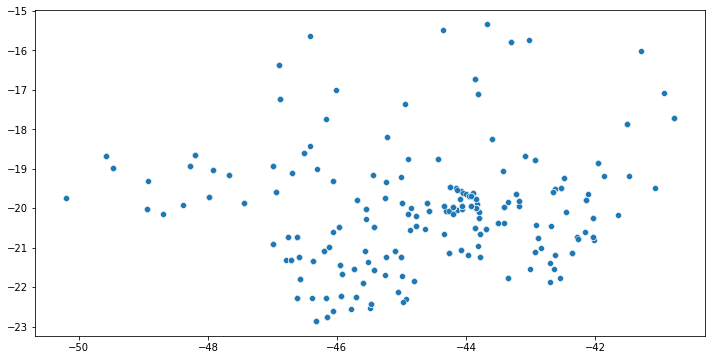

In [ ]:
plt.rcParams["figure.figsize"] = [12, 6]
sns.scatterplot(x=X[:,0], 
                y=X[:,1])
plt.show()

Opção pela retirada dos valores inexistentes uma vez que a sua representatividade é muito pequena dentro da base.

In [ ]:
ds_caged = ds_caged[~ds_caged['trabalhador_cbo_descr'].isna()]

In [ ]:
ds_caged 

,ano_mes_referencia,uf_cod,municipio_cod,cnpj_cnae,cnpj_secao,cnpj_tipo,cnpj_tam_jan,trabalhador_cbo,trabalhador_categoria,trabalhador_grauinstrucao,...,trabalhador_cbo_descr,trabalhador_categoria_descr,nome_municipio,trabalhador_racacor_descr,trabalhador_sexo_descr,GEOCODIGO_MUNICIPIO,NOME_MUNICIPIO,LONGITUDE,LATITUDE,trabalhador_movimentacao_target
0,202201,31,311800,3321000,C,0,9,514320,101,5,...,Faxineiro (Desativado em 2010),"Empregado - Geral, inclusive o empregado públi...",CONGONHAS,Não informada,Homem,311800,CONGONHAS,-43.856893,-20.504643,Desligamento
1,202201,31,310190,1052000,C,0,1,252210,101,7,...,Contador,"Empregado - Geral, inclusive o empregado públi...",ALPINÓPOLIS,Não informada,Homem,310190,ALPINÓPOLIS,-46.389483,-20.861855,Admissão
2,202201,31,311280,5510801,I,0,4,514320,101,7,...,Faxineiro (Desativado em 2010),"Empregado - Geral, inclusive o empregado públi...",CAPITÓLIO,Não informada,Mulher,311280,CAPITÓLIO,-46.054514,-20.614664,Admissão
3,202201,31,313820,7732201,N,0,3,521140,101,9,...,Atendente de Lojas e Mercados,"Empregado - Geral, inclusive o empregado públi...",LAVRAS,Branca,Homem,313820,LAVRAS,-44.999931,-21.242870,Admissão
4,202201,31,316570,4763602,G,0,3,521110,101,9,...,Vendedor de Comercio Varejista,"Empregado - Geral, inclusive o empregado públi...",SENADOR FIRMINO,Branca,Mulher,316570,SENADOR FIRMINO,-43.104130,-20.918060,Admissão
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3572974,202209,31,313800,4930202,H,0,1,782510,101,3,...,Motorista de Caminhao (Rotas Regionais e Inter...,"Empregado - Geral, inclusive o empregado públi...",LARANJAL,Parda,Homem,313800,LARANJAL,-42.480674,-21.363630,Desligamento
3572975,202209,31,310160,4754701,G,0,3,521110,101,7,...,Vendedor de Comercio Varejista,"Empregado - Geral, inclusive o empregado públi...",ALFENAS,Branca,Homem,310160,ALFENAS,-45.948918,-21.428178,Desligamento
3572976,202209,31,310620,8121400,N,0,8,517420,101,7,...,Vigia,"Empregado - Geral, inclusive o empregado públi...",BELO HORIZONTE,Preta,Homem,310620,BELO HORIZONTE,-43.926453,-19.937524,Desligamento
3572977,202209,31,310620,5611201,I,0,3,513205,101,7,...,Cozinheiro Geral,"Empregado - Geral, inclusive o empregado públi...",BELO HORIZONTE,Não informada,Mulher,310620,BELO HORIZONTE,-43.926453,-19.937524,Admissão


In [ ]:
ds_caged.isna().sum()

ano_mes_referencia                 0
uf_cod                             0
municipio_cod                      0
cnpj_cnae                          0
cnpj_secao                         0
cnpj_tipo                          0
cnpj_tam_jan                       0
trabalhador_cbo                    0
trabalhador_categoria              0
trabalhador_grauinstrucao          0
trabalhador_idade                  0
trabalhador_horascontratuais       0
trabalhador_racacor                0
trabalhador_sexo                   0
trabalhador_movimentacao           0
trabalhador_salario                0
trabalhador_movimentacao_descr     0
cnpj_tam_jan_descr                 0
trabalhador_grauinstrucao_descr    0
cnpj_secao_descr                   0
cnpj_cnae_descr                    0
trabalhador_cbo_descr              0
trabalhador_categoria_descr        0
nome_municipio                     0
trabalhador_racacor_descr          0
trabalhador_sexo_descr             0
GEOCODIGO_MUNICIPIO                0
N

## 1.2 - Tratamento e conversão de variáveis

In [ ]:
ds_caged.dtypes

ano_mes_referencia                   int64
uf_cod                               int64
municipio_cod                        int64
cnpj_cnae                            int64
cnpj_secao                          object
cnpj_tipo                            int64
cnpj_tam_jan                         int64
trabalhador_cbo                      int64
trabalhador_categoria                int64
trabalhador_grauinstrucao            int64
trabalhador_idade                    int64
trabalhador_horascontratuais       float64
trabalhador_racacor                  int64
trabalhador_sexo                     int64
trabalhador_movimentacao             int64
trabalhador_salario                float64
trabalhador_movimentacao_descr      object
cnpj_tam_jan_descr                  object
trabalhador_grauinstrucao_descr     object
cnpj_secao_descr                    object
cnpj_cnae_descr                     object
trabalhador_cbo_descr               object
trabalhador_categoria_descr         object
nome_munici

As variáveis foram devidamente tratadas sendo realizadas atividades de discretização e alteração de tipo na fase de estruturação do dataset, a partir dos dados coletados no site do MTE (Ministério do Trabalho e Emprego). Também foi feito a seleção de atributos e variáveis e limpeza dos dados durante essa fase.

# 2 - Projeto de experiência

O objetivo dos experimentos é prever a causa que um colaborador vai ser desligado do trabalho.

##2.1 - Definição do conjunto de dados de interesse

In [ ]:
ds_caged.columns

Index(['ano_mes_referencia', 'uf_cod', 'municipio_cod', 'cnpj_cnae',
       'cnpj_secao', 'cnpj_tipo', 'cnpj_tam_jan', 'trabalhador_cbo',
       'trabalhador_categoria', 'trabalhador_grauinstrucao',
       'trabalhador_idade', 'trabalhador_horascontratuais',
       'trabalhador_racacor', 'trabalhador_sexo', 'trabalhador_movimentacao',
       'trabalhador_salario', 'trabalhador_movimentacao_descr',
       'cnpj_tam_jan_descr', 'trabalhador_grauinstrucao_descr',
       'cnpj_secao_descr', 'cnpj_cnae_descr', 'trabalhador_cbo_descr',
       'trabalhador_categoria_descr', 'nome_municipio',
       'trabalhador_racacor_descr', 'trabalhador_sexo_descr',
       'GEOCODIGO_MUNICIPIO', 'NOME_MUNICIPIO', 'LONGITUDE', 'LATITUDE',
       'trabalhador_movimentacao_target'],
      dtype='object')

In [ ]:
# categoria de empregador CNPJ
ds_caged_fase1 = ds_caged.loc[ds_caged['cnpj_tipo'] == 0]

In [ ]:
#excluindo a coluna cnpj_tipo por conter somento o valor = 0 ->CNPJ
ds_caged_fase1 = ds_caged_fase1.drop('cnpj_tipo', axis='columns')

In [ ]:
# selecionando o tipomovimentação de interesse = 10, 20, 35, 31, 32, 33, 40, 90 (admissões e demissões - trabalho clt não temporário) - fase 1
ds_caged_fase1 = ds_caged_fase1.loc[ds_caged_fase1['trabalhador_movimentacao'].isin([10, 20, 35, 31, 32, 33, 40, 90])]

In [ ]:
# selecionando Categoria de trabalhador para somente contratos de longo prazo
ds_caged_fase1 = ds_caged_fase1.loc[ds_caged_fase1['trabalhador_categoria'].isin([101, 102, 107, 108])]

In [ ]:
# separando a base de demitidos
ds_caged_fase1_dem = ds_caged_fase1.loc[ds_caged_fase1['trabalhador_movimentacao_target'] == 'Desligamento']

In [ ]:
ds_caged_fase1_dem.columns

Index(['ano_mes_referencia', 'uf_cod', 'municipio_cod', 'cnpj_cnae',
       'cnpj_secao', 'cnpj_tam_jan', 'trabalhador_cbo',
       'trabalhador_categoria', 'trabalhador_grauinstrucao',
       'trabalhador_idade', 'trabalhador_horascontratuais',
       'trabalhador_racacor', 'trabalhador_sexo', 'trabalhador_movimentacao',
       'trabalhador_salario', 'trabalhador_movimentacao_descr',
       'cnpj_tam_jan_descr', 'trabalhador_grauinstrucao_descr',
       'cnpj_secao_descr', 'cnpj_cnae_descr', 'trabalhador_cbo_descr',
       'trabalhador_categoria_descr', 'nome_municipio',
       'trabalhador_racacor_descr', 'trabalhador_sexo_descr',
       'GEOCODIGO_MUNICIPIO', 'NOME_MUNICIPIO', 'LONGITUDE', 'LATITUDE',
       'trabalhador_movimentacao_target'],
      dtype='object')

In [ ]:
ds_caged_fase1_dem.drop(columns=['GEOCODIGO_MUNICIPIO', 'uf_cod'], inplace=True)

##2.2 - analise descritiva da base de dados

In [ ]:
def grafico(variavel=None):
    if variavel == None:
        corr = ds_caged_fase1_dem.corr()
    else:
        corr = ds_caged_fase1_dem[ds_caged_fase1_dem['trabalhador_movimentacao_descr'] == variavel].corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    plt.figure(figsize=(14,8))

    plt.title("Correlação geral das variáveis", fontsize=18)

    sns.heatmap(corr, mask=mask, annot=True, cmap="RdYlGn", linewidths=0.2, annot_kws={'size':10})

    plt.show()

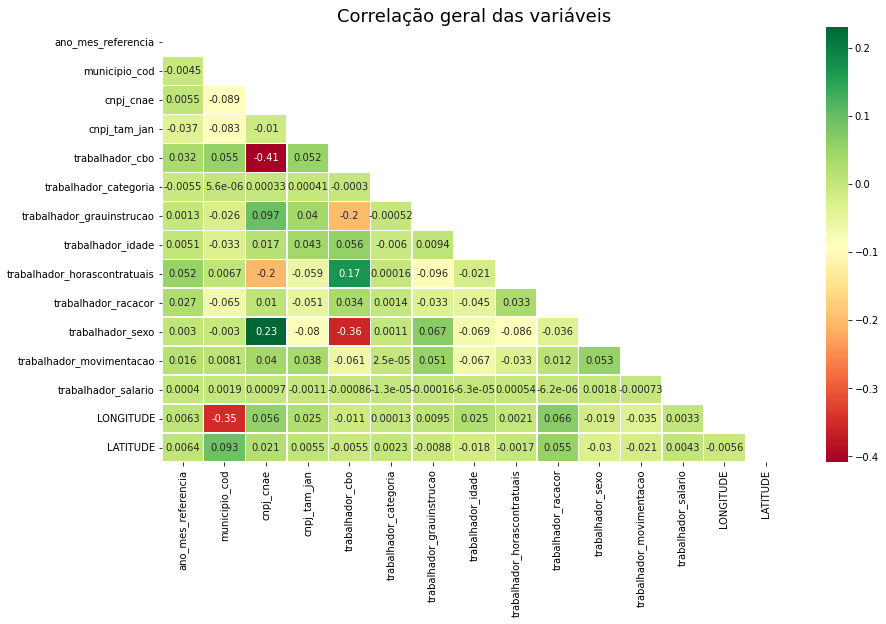

In [ ]:
grafico()

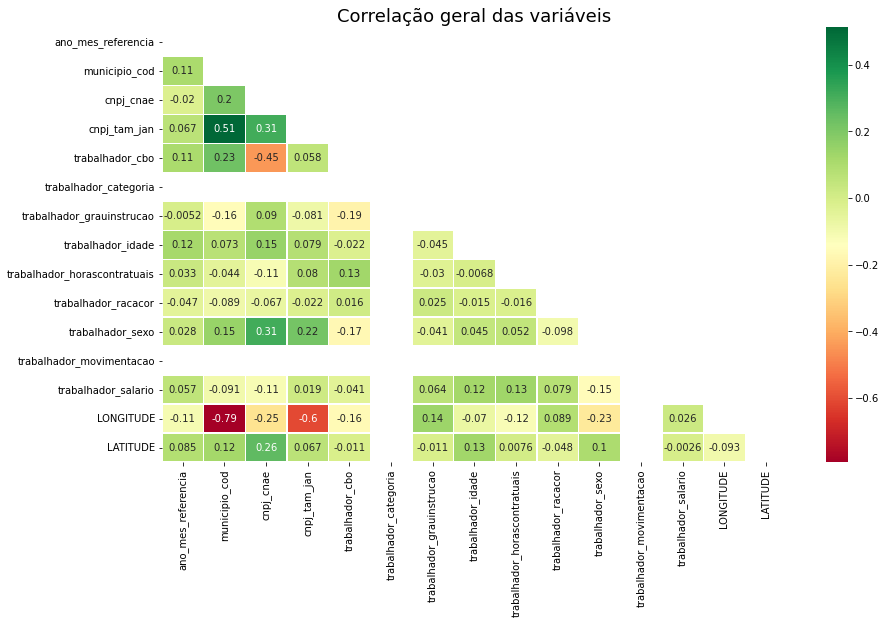

In [ ]:
grafico(variavel='Culpa Recíproca')

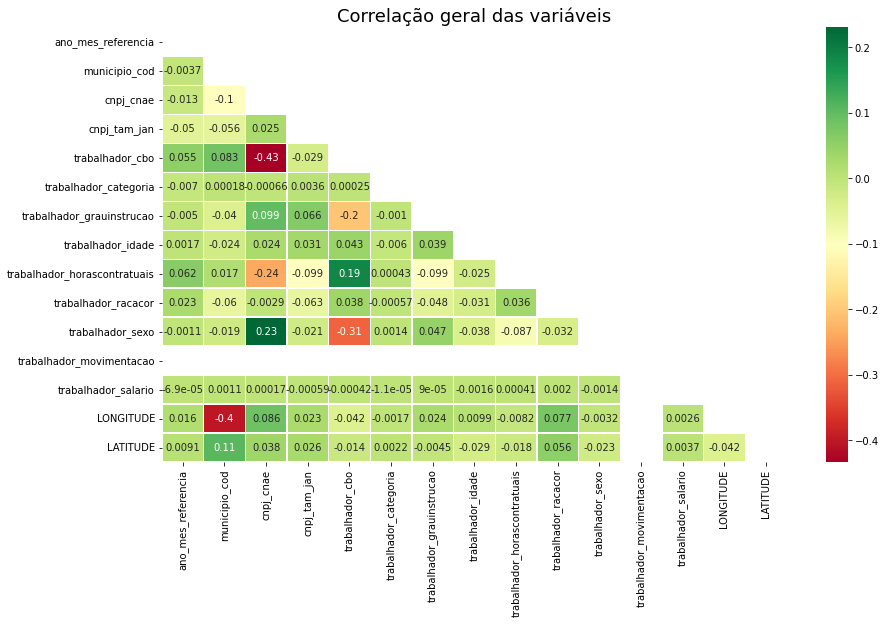

In [ ]:
grafico(variavel='Desligamento a pedido')

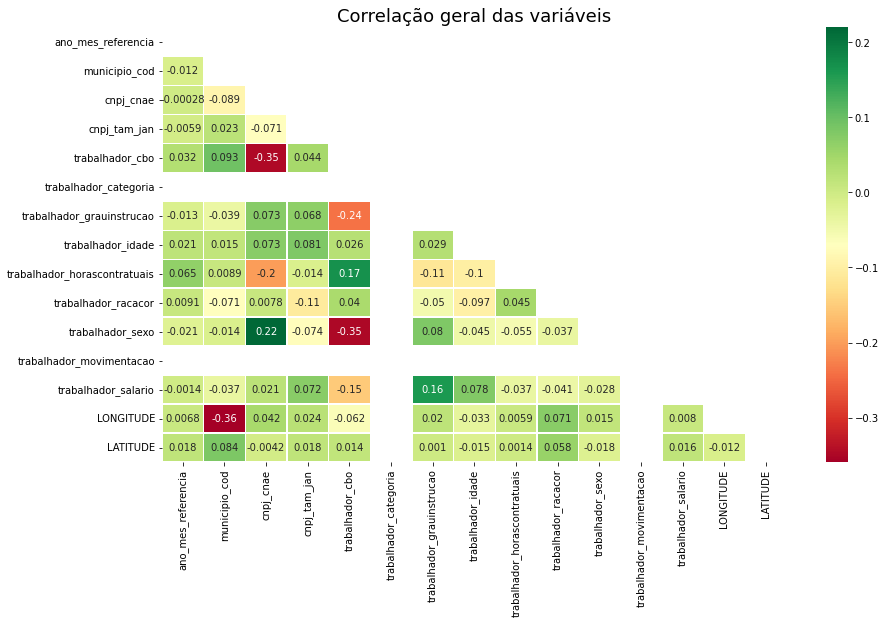

In [ ]:
grafico(variavel='Desligamento por Acordo entre empregado e empregador')

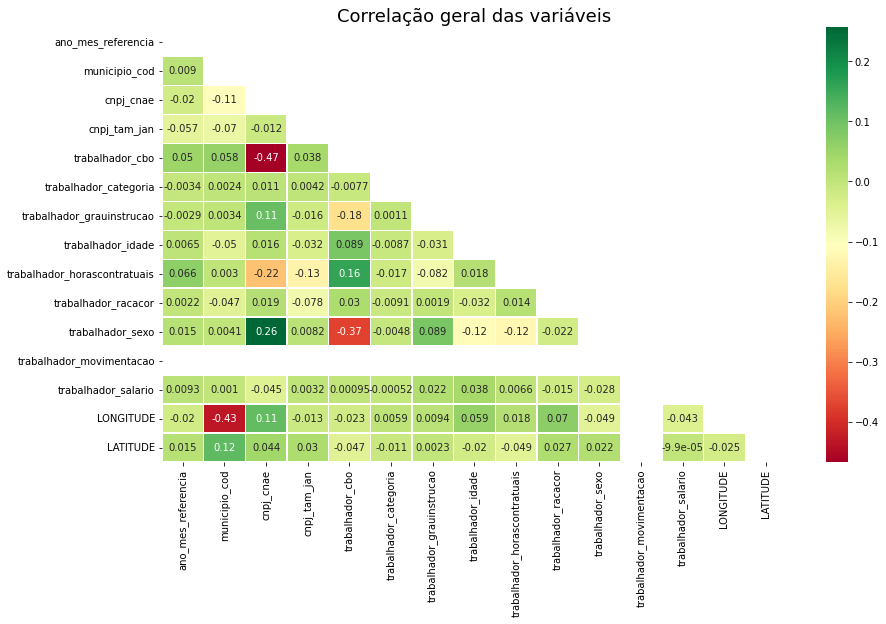

In [ ]:
grafico(variavel='Desligamento por demissão com justa causa')

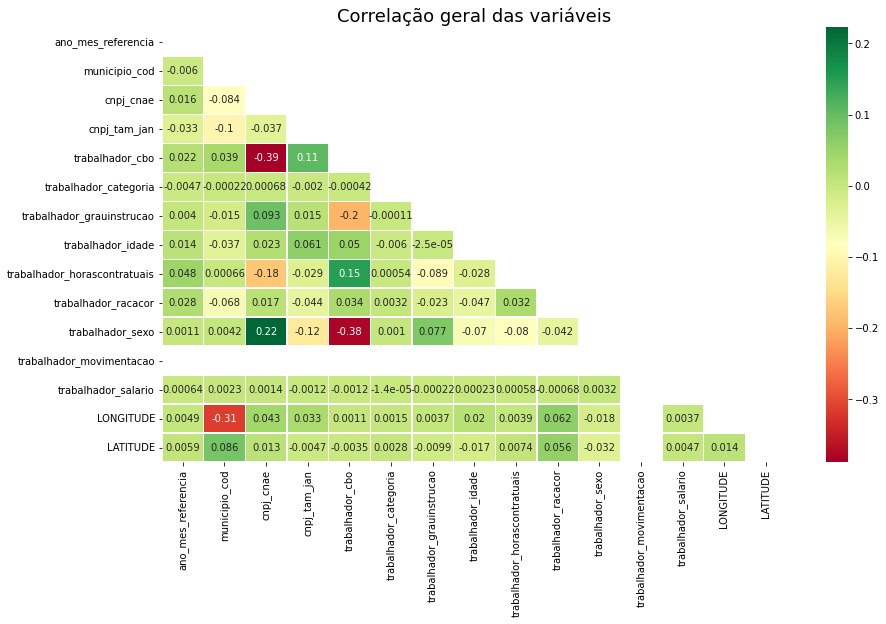

In [ ]:
grafico(variavel='Desligamento por demissão sem justa causa')

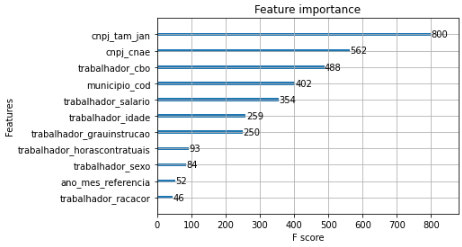

In [ ]:
# create_report(ds_caged_fase1_dem)

# Implementação

In [ ]:
ds_caged_fase1_dem.columns

Index(['ano_mes_referencia', 'municipio_cod', 'cnpj_cnae', 'cnpj_secao',
       'cnpj_tam_jan', 'trabalhador_cbo', 'trabalhador_categoria',
       'trabalhador_grauinstrucao', 'trabalhador_idade',
       'trabalhador_horascontratuais', 'trabalhador_racacor',
       'trabalhador_sexo', 'trabalhador_movimentacao', 'trabalhador_salario',
       'trabalhador_movimentacao_descr', 'cnpj_tam_jan_descr',
       'trabalhador_grauinstrucao_descr', 'cnpj_secao_descr',
       'cnpj_cnae_descr', 'trabalhador_cbo_descr',
       'trabalhador_categoria_descr', 'nome_municipio',
       'trabalhador_racacor_descr', 'trabalhador_sexo_descr', 'NOME_MUNICIPIO',
       'LONGITUDE', 'LATITUDE', 'trabalhador_movimentacao_target'],
      dtype='object')

In [ ]:
# variaveis = ['municipio_cod', 'cnpj_cnae', 'cnpj_tam_jan', 'trabalhador_cbo', 'trabalhador_grauinstrucao', 'trabalhador_idade', 'trabalhador_salario', 'trabalhador_sexo']
variaveis = ['municipio_cod', 'cnpj_cnae', 'cnpj_tam_jan', 'trabalhador_cbo', 'trabalhador_sexo']

In [ ]:
trabalhador_salario_95 = np.percentile(ds_caged_fase1_dem['trabalhador_salario'], 95)

# separando conjunto de amostras e de respostas
X = ds_caged_fase1_dem.loc[ds_caged_fase1_dem['trabalhador_salario'] < trabalhador_salario_95, variaveis]
y = ds_caged_fase1_dem.loc[ds_caged_fase1_dem['trabalhador_salario'] < trabalhador_salario_95, 'trabalhador_movimentacao_descr']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 13)

## 1 - Decision Tree

In [ ]:
# implementação e visualização do modelo de árvore de decisões
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import classification_report

In [ ]:
clf = DecisionTreeClassifier(criterion = 'entropy')
clf.fit(X_train, y_train)

resultados_corretos = y_test
resultados_arvore = clf.predict(X_test)
precisao = accuracy_score(resultados_corretos, resultados_arvore)
print(f'A acurácia do método é de {str(round(precisao*100, 2))}%.')

A acurácia do método é de 63.5%.


In [ ]:
print(classification_report(resultados_corretos, resultados_arvore))

                                                      precision    recall  f1-score   support

                                     Culpa Recíproca       0.32      0.22      0.26       207
                               Desligamento a pedido       0.53      0.55      0.54     92523
Desligamento por Acordo entre empregado e empregador       0.16      0.10      0.13      2689
           Desligamento por demissão com justa causa       0.08      0.02      0.03      3641
           Desligamento por demissão sem justa causa       0.71      0.71      0.71    153619

                                            accuracy                           0.63    252679
                                           macro avg       0.36      0.32      0.33    252679
                                        weighted avg       0.63      0.63      0.63    252679



In [ ]:
r = export_text(clf, feature_names=variaveis, max_depth=3)
print(r)

|--- cnpj_cnae <= 4635401.50
|   |--- cnpj_cnae <= 3811800.00
|   |   |--- cnpj_tam_jan <= 5.50
|   |   |   |--- cnpj_tam_jan <= 1.50
|   |   |   |   |--- truncated branch of depth 37
|   |   |   |--- cnpj_tam_jan >  1.50
|   |   |   |   |--- truncated branch of depth 48
|   |   |--- cnpj_tam_jan >  5.50
|   |   |   |--- cnpj_cnae <= 2315850.00
|   |   |   |   |--- truncated branch of depth 34
|   |   |   |--- cnpj_cnae >  2315850.00
|   |   |   |   |--- truncated branch of depth 34
|   |--- cnpj_cnae >  3811800.00
|   |   |--- cnpj_tam_jan <= 7.50
|   |   |   |--- cnpj_cnae <= 4311801.50
|   |   |   |   |--- truncated branch of depth 48
|   |   |   |--- cnpj_cnae >  4311801.50
|   |   |   |   |--- truncated branch of depth 50
|   |   |--- cnpj_tam_jan >  7.50
|   |   |   |--- cnpj_cnae <= 4316350.00
|   |   |   |   |--- truncated branch of depth 26
|   |   |   |--- cnpj_cnae >  4316350.00
|   |   |   |   |--- truncated branch of depth 21
|--- cnpj_cnae >  4635401.50
|   |--- cnpj_tam_

## 2 - Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=0)

clf.fit(X_train, y_train)

resultados_corretos = y_test
resultados_arvore = clf.predict(X_test)
precisao = accuracy_score(resultados_corretos, resultados_arvore)
print(f'A acurácia do método é de {str(round(precisao*100, 2))}%.')

A acurácia do método é de 60.8%.


In [ ]:
print(classification_report(resultados_corretos, resultados_arvore))

                                                      precision    recall  f1-score   support

                                     Culpa Recíproca       0.00      0.00      0.00       207
                               Desligamento a pedido       0.00      0.00      0.00     92523
Desligamento por Acordo entre empregado e empregador       0.00      0.00      0.00      2689
           Desligamento por demissão com justa causa       0.00      0.00      0.00      3641
           Desligamento por demissão sem justa causa       0.61      1.00      0.76    153619

                                            accuracy                           0.61    252679
                                           macro avg       0.12      0.20      0.15    252679
                                        weighted avg       0.37      0.61      0.46    252679



## 3 - Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
clf = GradientBoostingClassifier(n_estimators=1, learning_rate=1.0, max_depth=1, random_state=0)

clf.fit(X_train, y_train)

resultados_corretos = y_test
resultados_arvore = clf.predict(X_test)
precisao = accuracy_score(resultados_corretos, resultados_arvore)
print(f'A acurácia do método é de {str(round(precisao*100, 2))}%.')

A acurácia do método é de 60.8%.


In [ ]:
print(classification_report(resultados_corretos, resultados_arvore))

                                                      precision    recall  f1-score   support

                                     Culpa Recíproca       0.00      0.00      0.00       207
                               Desligamento a pedido       0.00      0.00      0.00     92523
Desligamento por Acordo entre empregado e empregador       0.00      0.00      0.00      2689
           Desligamento por demissão com justa causa       0.00      0.00      0.00      3641
           Desligamento por demissão sem justa causa       0.61      1.00      0.76    153619

                                            accuracy                           0.61    252679
                                           macro avg       0.12      0.20      0.15    252679
                                        weighted avg       0.37      0.61      0.46    252679



## 4 - XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
xgb_clf = xgb.XGBClassifier()

xgb_clf.fit(X_train, y_train)

resultados_corretos = y_test

resultados_arvore = xgb_clf.predict(X_test)
precisao = accuracy_score(resultados_corretos, resultados_arvore)
print(f'A acurácia do método é de {str(round(precisao*100, 2))}%.')

A acurácia do método é de 63.39%.


In [ ]:
print(classification_report(resultados_corretos, resultados_arvore))

                                                      precision    recall  f1-score   support

                                     Culpa Recíproca       0.00      0.00      0.00       207
                               Desligamento a pedido       0.57      0.22      0.32     92523
Desligamento por Acordo entre empregado e empregador       0.00      0.00      0.00      2689
           Desligamento por demissão com justa causa       0.00      0.00      0.00      3641
           Desligamento por demissão sem justa causa       0.64      0.91      0.75    153619

                                            accuracy                           0.63    252679
                                           macro avg       0.24      0.23      0.21    252679
                                        weighted avg       0.60      0.63      0.58    252679



## 5 - Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [ ]:
nn_clf = MLPClassifier(solver='adam', hidden_layer_sizes=(2,), learning_rate_init=2, activation='relu', max_iter=3500, random_state=780)

nn_clf.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(2,), learning_rate_init=2, max_iter=3500,
              random_state=780)

In [ ]:
resultados_corretos = y_test

resultados_arvore = nn_clf.predict(X_test)
precisao = accuracy_score(y_test, resultados_arvore)
print(f'A acurácia do método é de {str(round(precisao*100, 2))}%.')

A acurácia do método é de 60.8%.


In [ ]:
print(classification_report(resultados_corretos, resultados_arvore))

                                                      precision    recall  f1-score   support

                                     Culpa Recíproca       0.00      0.00      0.00       207
                               Desligamento a pedido       0.00      0.00      0.00     92523
Desligamento por Acordo entre empregado e empregador       0.00      0.00      0.00      2689
           Desligamento por demissão com justa causa       0.00      0.00      0.00      3641
           Desligamento por demissão sem justa causa       0.61      1.00      0.76    153619

                                            accuracy                           0.61    252679
                                           macro avg       0.12      0.20      0.15    252679
                                        weighted avg       0.37      0.61      0.46    252679



## 6 - Linear Discriminant Analysis

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=4)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

In [ ]:
classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train_lda, y_train)
y_pred = classifier.predict(X_test_lda)

In [ ]:
precisao = accuracy_score(y_test, y_pred)
print(f'A acurácia do método é de {str(round(precisao*100, 2))}%.')

A acurácia do método é de 60.8%.


In [ ]:
print(classification_report(y_test, y_pred))

                                                      precision    recall  f1-score   support

                                     Culpa Recíproca       0.00      0.00      0.00       207
                               Desligamento a pedido       0.00      0.00      0.00     92523
Desligamento por Acordo entre empregado e empregador       0.00      0.00      0.00      2689
           Desligamento por demissão com justa causa       0.00      0.00      0.00      3641
           Desligamento por demissão sem justa causa       0.61      1.00      0.76    153619

                                            accuracy                           0.61    252679
                                           macro avg       0.12      0.20      0.15    252679
                                        weighted avg       0.37      0.61      0.46    252679



## 7 - kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=31)

neigh.fit(X_train, y_train)

resultados_corretos = y_test

resultados_arvore = neigh.predict(X_test)
precisao = accuracy_score(resultados_corretos, resultados_arvore)
print(f'A acurácia do método é de {str(round(precisao*100, 2))}%.')

A acurácia do método é de 64.93%.


In [ ]:
print(classification_report(resultados_corretos, resultados_arvore))

                                                      precision    recall  f1-score   support

                                     Culpa Recíproca       0.46      0.22      0.30       207
                               Desligamento a pedido       0.56      0.39      0.46     92523
Desligamento por Acordo entre empregado e empregador       0.52      0.03      0.06      2689
           Desligamento por demissão com justa causa       0.52      0.01      0.02      3641
           Desligamento por demissão sem justa causa       0.68      0.83      0.75    153619

                                            accuracy                           0.65    252679
                                           macro avg       0.55      0.30      0.32    252679
                                        weighted avg       0.63      0.65      0.62    252679

